# `PHAS0102 Assignment 2 - solving two 1D problems - part two`

In [ ]:
import matplotlib.pyplot as plt
import math
import numba
from numba import jit, njit, prange, cuda
import numpy as np
from scipy import sparse
from timeit import timeit
from tqdm import tqdm

In [ ]:
!uv pip install -q --system numba-cuda==0.4.0 # COLAB ONLY
from numba import config # COLAB ONLY
config.CUDA_ENABLE_PYNVJITLINK = 1 # COLAB ONLY

!pip install numba==0.59.1 -q
!pip install cuda-python -q
!pip install numpy==1.26.4 -q

In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-594486d2-d27d-757f-204f-84fedd0d516d
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## `part 2: solving the heat equation w/ GPU acceleration`

The heat equation is a parabolic partial differential equation, and it models how heat diffuses through a region over time. The following equations model heat transfer in a 1-dimensional rod of length 1, that is heated to 10 at both ends.
$$
\begin{align*}
\frac{du}{dt} &= \frac{1}{1000} \frac{d^2 u}{dx^2}, & x &\in (0,1), \\
u(x,0) &= 0, & \text{for } x &\neq 0 \text{ and } x \neq 1, \\
u(0,t) &= 10, \\
u(1,t) &= 10.
\end{align*}
$$  

This can be solved approximately using an iterative approach. Take evenly spaced values $x_0 = x_1,x_2,...,x_N=1$ and evenly spaced time values $t_0=0,t_1=h,t_2=2h,...,$ where $h=1/N$. The shorthand $u_i^{(j)}\approx u(x_i,t_j)$ is used hereafter. By approximating derivatives, we are lead to an iterative method for solving this problem: first, at  $t = 0$, we set  

$$
u_i^{(0)} =
\begin{cases}
10 & \text{if } i = 0 \text{ or } i = N, \\
0 & \text{otherwise};
\end{cases}
$$

then for all later values of time, we set  

$$
u_i^{(j+1)} =
\begin{cases}
10 & \text{if } i = 0 \text{ or } i = N, \\
u_i^{(j)} + \dfrac{u_{i-1}^{(j)} - 2u_i^{(j)} + u_{i+1}^{(j)}}{1000h} & \text{otherwise.}
\end{cases}
$$


### `2a`
Implementing iterative scheme in python.

In [ ]:
def heat_equation(N, time_steps=200000):
    """
    description:
        models heat equation iteratively
    inputs:
        N: number of x-values that the rod is split up into, int
        time_steps: number of time_steps to iterate over, int (2e5 by default)
    outputs:
        A: array of solutions to heat equation, dimensions of N x time_steps
           each row is a representation of the heat distribution in the rod at succesive time steps
           row to row transformation indicates evolution of heat distribution in rod over time
    """
    h = 1/N  # time step
    A = np.zeros((time_steps+1, N+1),
                 dtype=np.float32)    # initialising empty array to store values

    # enforcing boundary conditions i.e. ensuring rod is heated to 10 for whole time evolution
    initial_temp = 10

    A[:,0] = initial_temp
    A[:,-1] = initial_temp

    # iterating over time steps and x values to form approximate solutions
    for j in range(time_steps):
        for i in range(1,N):
            A[j+1][i] = A[j][i] + (A[j][i-1] - 2*A[j][i] + A[j][i+1]) / (1000*h)

    return A

### `2b`
Plotting temperature of the rod at $t=1$, $t=2$, and $t=10$. $N=400$ was chosen as a suitable tradeoff betewen good spatial resolution in the temperature distribution of the rod, and approaching values of x that caused errors in iteration calculations due to rounding errors in the floating point arithmetic. High $N$ values also causes explosion in computation time. 200,000 time steps were chosen to allow enough iterations for significant time evolution.

In [ ]:
N = 400

heat_evolution = heat_equation(int(N))
x_values = np.linspace(0, 1, int(N+1))

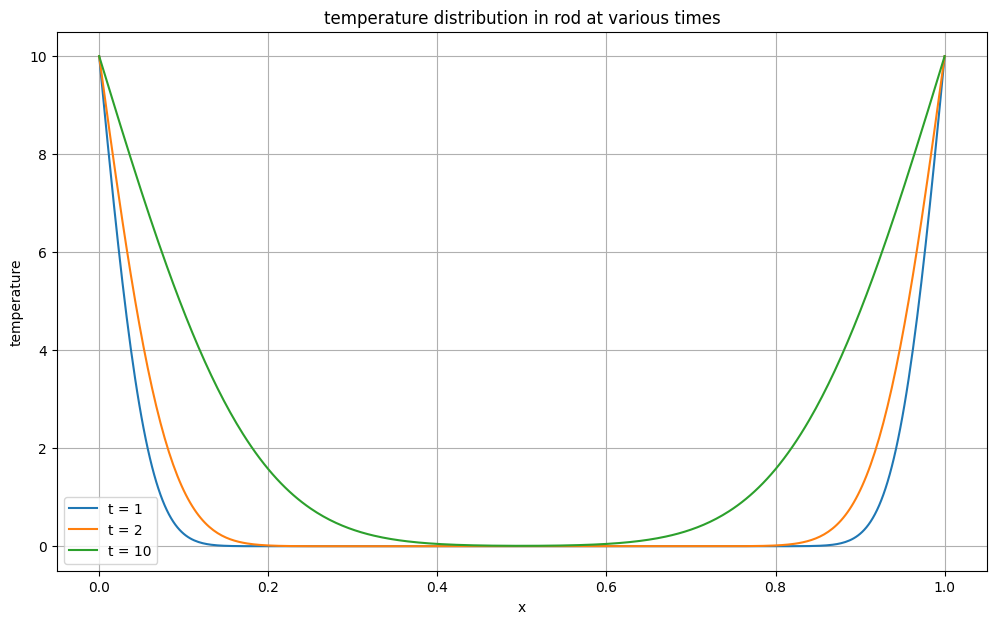

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(x_values, heat_evolution[N*1], label='t = 1')
plt.plot(x_values, heat_evolution[N*2], label='t = 2')
plt.plot(x_values, heat_evolution[N*10], label='t = 10')

plt.title('temperature distribution in rod at various times')
plt.xlabel('x')
plt.ylabel('temperature')

plt.legend()
plt.grid()
plt.show()

### `2c: GPU parallelisation`
`numba.cuda` will be used to optimise above code for execution in parallel on GPU.

In [ ]:
@cuda.jit
def update_step(A_now, A_next, N, h):
    """
    description:
        performs one update step of heat evolution simulation
        each thread updates one element of temperature array (apart from boundaries)
    inputs:
        A_now: device array of current temperature values, float32
        A_prev: device array of next step temperature values, float32
        N: number of x-values that rod is split into, int
        h: step size (1/N), float
    """
    # compute global thread index
    i = cuda.grid(1)

    # iterating over time steps and x values to form approximate solutions
    if 1 <= i < N:
        A_next[i] = A_now[i] + (A_now[i-1] - 2*A_now[i] + A_now[i+1]) / (1000*h)


def heat_evolution_solve(N, time_limit=200000, initial_temp=10):
    """
    description:
        runs heat diffusion simulation, utilising parallel computation with CUDA
        simulation terminates either when midpoint of rod reachs temperature of 9.8, or time limit runs out
    inputs:
        N: number of x-values that rod is split into, int
        time_limit: maximum number of time steps to simulate
        initial_temp: boundary temperature
    outputs:
        A_now: final heat distribution, numpy.array
        time_point: time when midpoint reaches 9.8
    """
    h = 1/N

    # intialising array with zeros (interior of rod at T=0)
    A = np.zeros(N+1, dtype=np.float32)

    # enforcing boundary conditions (ends of rod at T=10)
    A[0] = 10.0
    A[-1] = 10.0

    # copying arrays to GPU for step update function
    A_now = cuda.to_device(A)
    A_next = cuda.to_device(A)

    # CUDA kernel configuration
    blockdim = 256                      # number of threads per block
    griddim = math.ceil((N+1)/blockdim) # number of thread blocks

    # time evolution loop
    for time_point in range(time_limit):
        # update
        update_step[griddim, blockdim](A_now, A_next, N, h)

        # enforce boundary conditions
        A_next[0] = initial_temp
        A_next[N] = initial_temp

        # swap references for next loop
        A_now, A_next = A_next, A_now

        # midpoint temperature check
        if A_now[N//2] >= 9.8:
            print()
            print(f'midpoint reached 9.8 at t = {time_point/400:.2f}')
            return A_now.copy_to_host(), time_point/400

        return A_now.copy_to_host(), time_point/400

In [ ]:
cuda_heat_evolution, time_point = heat_evolution_solve(N)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



midpoint reached 9.8 at t = 421.66


Here, a two-function method was used to calculate the time taken for the midpoint of the rod to reach 9.8. The first function performs a parallelised step update on the heat distribution in the rod, and the second function uses that parallelised step update to run the whole simulation over the total time step range. We utilise a loop break to stop the iteration as soon as the temperature exceeds 9.8, and the time at which that happens, as well as the heat distribution at the time is returned. With our parameters, it is shown that the midpoint reaches $T=9.8$ at $t=421.7s$.  